In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

**Primary Analysis**

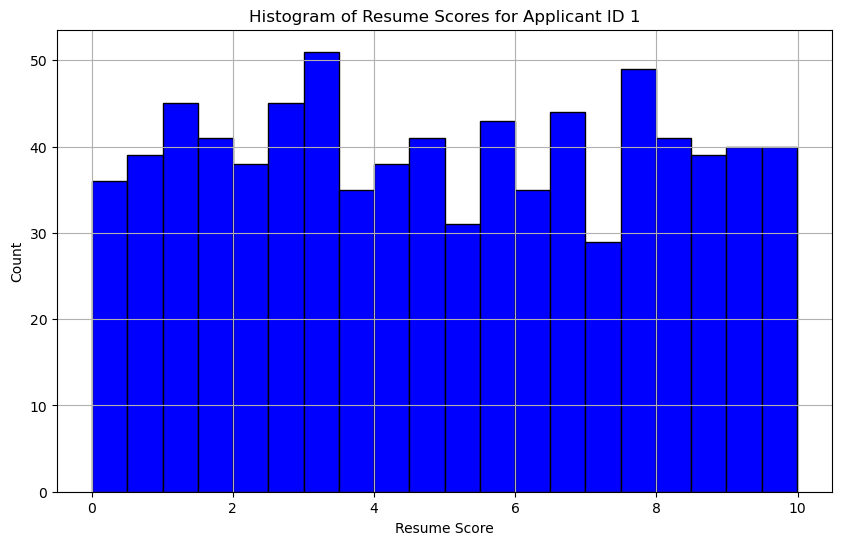

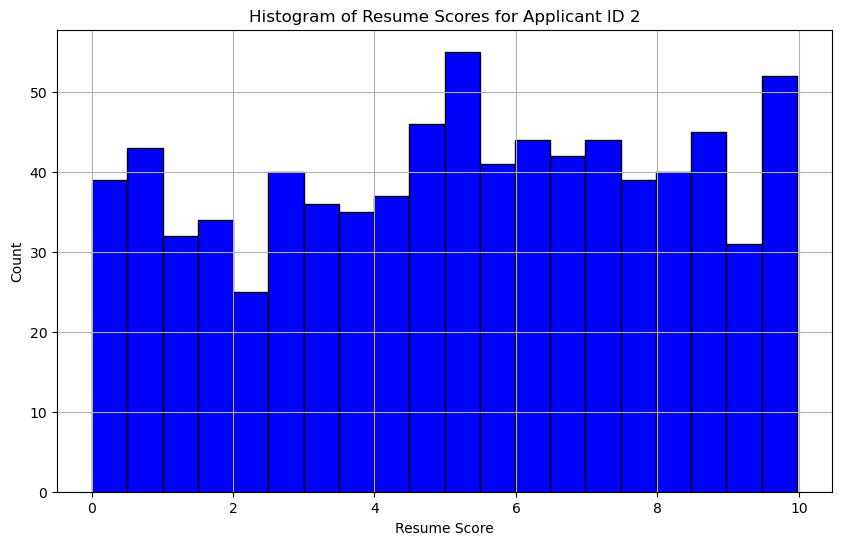

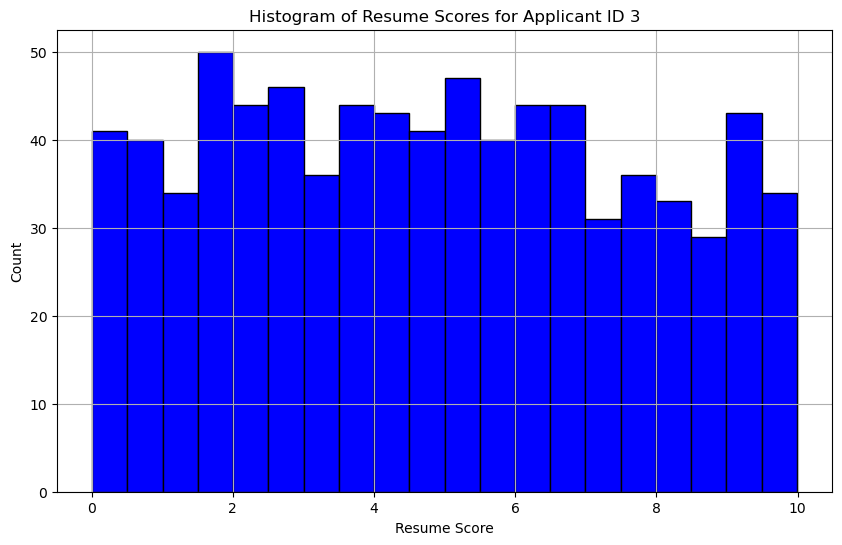

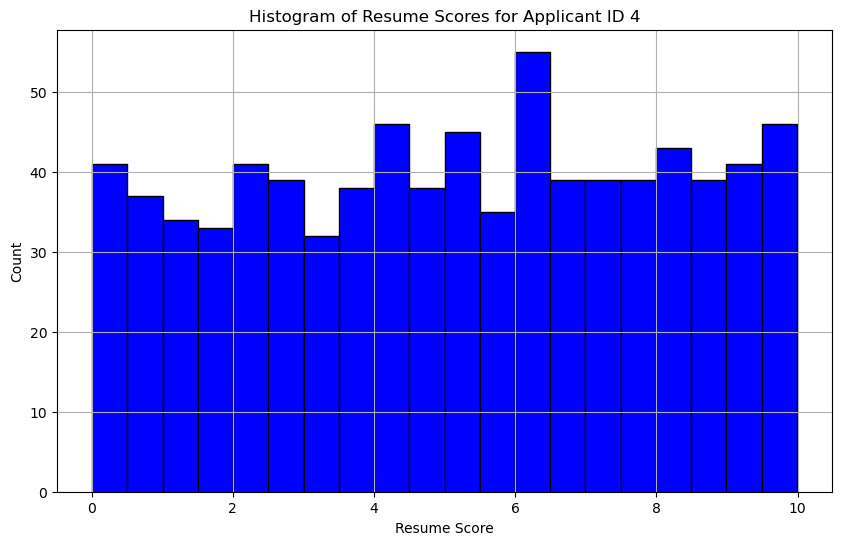

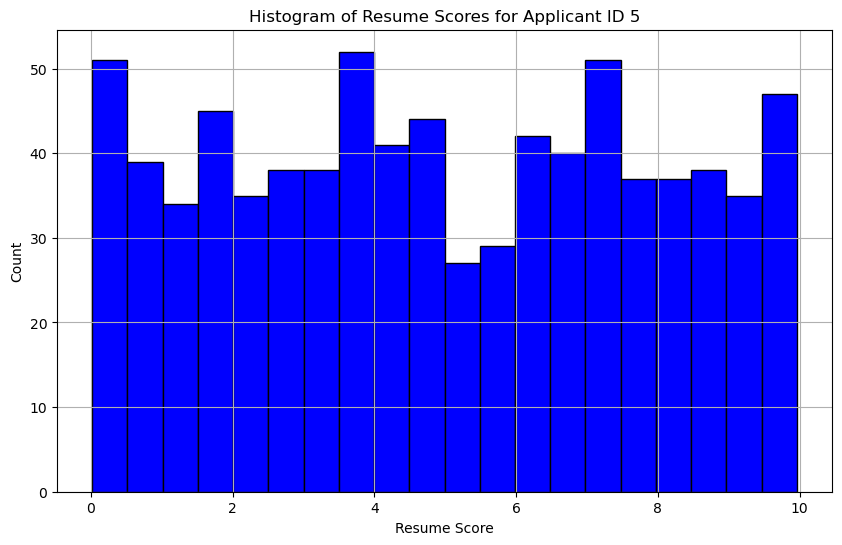

In [13]:
results_data = pd.read_csv('./Primary Analysis/resume_results_large.csv')
unique_ids = results_data['applicant_id'].unique()[:5]

for app_id in unique_ids:
    app_data = results_data[results_data['applicant_id'] == app_id]
    plt.figure(figsize=(10, 6))
    plt.hist(app_data['score'], bins=20, color='blue', edgecolor='black')
    plt.title(f'Histogram of Resume Scores for Applicant ID {app_id}')
    plt.xlabel('Resume Score')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()


**Testing Candidate Evaluator Model**

**Data Creation for the ML Model**

In [157]:
np.random.seed(42)
directory_path = "./dataset_trial/"

num_rows = 4000
fixed_school_name = 'Providence University'
fixed_gpa = 4.0
fixed_degree = 'Bachelors'
fixed_location = 'Providence'
fixed_role = 'Junior SWE'
fixed_start_date = pd.to_datetime('2018-01-01').strftime('%m/%y')  # '01/18'
fixed_end_date = pd.to_datetime('2019-01-01').strftime('%m/%y')    # '01/19'

gender_options = ['M', 'F', 'N/A']
gender_probabilities = [0.45, 0.45, 0.1]

veteran_options = ['0', '1', 'N/A']
veteran_probabilities = [0.7, 0.25, 0.05]

work_authorization_options = ['0', '1']
work_authorization_probabilities = [0.2, 0.8]

disability_options = ['0', '1', 'N/A']
disability_probabilities = [0.85, 0.1, 0.05]

ethnicity_options = ['0', '1', '2', '3', '4']
ethnicity_probabilities = [0.2, 0.2, 0.2, 0.2, 0.2]

control_data = pd.DataFrame({
    'Applicant ID': range(1, num_rows + 1),
    'School Name': [fixed_school_name] * num_rows,
    'GPA': [fixed_gpa] * num_rows,
    'Degree': [fixed_degree] * num_rows,
    'Location': [fixed_location] * num_rows,
    'Gender': np.random.choice(gender_options, num_rows, p=gender_probabilities),
    'Veteran status': np.random.choice(veteran_options, num_rows, p=veteran_probabilities),
    'Work authorization': np.random.choice(work_authorization_options, num_rows, p=work_authorization_probabilities),
    'Disability': np.random.choice(disability_options, num_rows, p=disability_probabilities),
    'Ethnicity': np.random.choice(ethnicity_options, num_rows, p=ethnicity_probabilities),
    'Role 1': [fixed_role] * num_rows,
    'Start 1': [fixed_start_date] * num_rows,
    'End 1': [fixed_end_date] * num_rows,
    'Role 2': ["N/A"] * num_rows,
    'Start 2': ["N/A"] * num_rows,
    'End 2': ["N/A"] * num_rows,
    'Role 3': ["N/A"] * num_rows,
    'Start 3': ["N/A"] * num_rows,
    'End 3': ["N/A"] * num_rows,
    'Resume score': [8.5] * num_rows
})

control_file_name = f"{directory_path}control_data.csv"
control_data.to_csv(control_file_name, index=False)
print(f"Control data has been saved to '{control_file_name}'.")


Control data has been saved to '/Users/stefano/Desktop/CSCI1951Z/dataset_trial/control_data.csv'.


In [158]:
file_mapping = {
    "gender_m": "gender_male_data.csv",
    "gender_f": "gender_female_data.csv",
    "gender_n/a": "gender_n_a_data.csv",
    "veteran_status_0": "veteran_status_non_veteran_data.csv",
    "veteran_status_1": "veteran_status_veteran_data.csv",
    "veteran_status_n/a": "veteran_status_n_a_data.csv",
    "work_authorization_0": "work_authorization_not_authorized_data.csv",
    "work_authorization_1": "work_authorization_authorized_data.csv",
    "disability_0": "disability_no_disability_data.csv",
    "disability_1": "disability_disability_data.csv",
    "disability_n/a": "disability_n_a_data.csv",
    "ethnicity_0": "ethnicity_white_data.csv",
    "ethnicity_1": "ethnicity_black_data.csv",
    "ethnicity_2": "ethnicity_native_american_data.csv",
    "ethnicity_3": "ethnicity_asian_data.csv",
    "ethnicity_4": "ethnicity_other_data.csv"
}

attributes = [
    ('gender', gender_options),
    ('veteran_status', veteran_options),
    ('work_authorization', work_authorization_options),
    ('disability', disability_options),
    ('ethnicity', ethnicity_options)
]

for attribute_name, options in attributes:
    for option in options:
        data = pd.DataFrame({
            'Applicant ID': range(1, num_rows + 1),
            'School Name': [fixed_school_name] * num_rows,
            'GPA': [fixed_gpa] * num_rows,
            'Degree': [fixed_degree] * num_rows,
            'Location': [fixed_location] * num_rows,

            'Gender': np.random.choice(gender_options, num_rows,p=gender_probabilities) if attribute_name != 'gender' else [option] * num_rows,
            'Veteran status': np.random.choice(veteran_options, num_rows,p=veteran_probabilities) if attribute_name != 'veteran_status' else [option] * num_rows,
            'Work authorization': np.random.choice(work_authorization_options, num_rows,p=work_authorization_probabilities) if attribute_name != 'work_authorization' else [option] * num_rows,
            'Disability': np.random.choice(disability_options, num_rows,p=disability_probabilities) if attribute_name != 'disability' else [option] * num_rows,
            'Ethnicity': np.random.choice(ethnicity_options, num_rows,p=ethnicity_probabilities) if attribute_name != 'ethnicity' else [option] * num_rows,

            'Role 1': [fixed_role] * num_rows,
            'Start 1': [fixed_start_date] * num_rows,
            'End 1': [fixed_end_date] * num_rows,
            'Role 2': ["N/A"] * num_rows,
            'Start 2': ["N/A"] * num_rows,
            'End 2': ["N/A"] * num_rows,
            'Role 3': ["N/A"] * num_rows,
            'Start 3': ["N/A"] * num_rows,
            'End 3': ["N/A"] * num_rows,
            'Resume score': [8.5] * num_rows
        })

        key = f"{attribute_name}_{option.lower().replace(' ', '_').replace('/', '_')}"
        preferred_filename = file_mapping.get(key, f"{key}_data.csv")

        file_name = directory_path + preferred_filename
        data.to_csv(file_name, index=False)
        print(f"Data has been saved to '{file_name}'.")

Data has been saved to '/Users/stefano/Desktop/CSCI1951Z/dataset_trial/gender_male_data.csv'.
Data has been saved to '/Users/stefano/Desktop/CSCI1951Z/dataset_trial/gender_female_data.csv'.
Data has been saved to '/Users/stefano/Desktop/CSCI1951Z/dataset_trial/gender_n_a_data.csv'.
Data has been saved to '/Users/stefano/Desktop/CSCI1951Z/dataset_trial/veteran_status_non_veteran_data.csv'.
Data has been saved to '/Users/stefano/Desktop/CSCI1951Z/dataset_trial/veteran_status_veteran_data.csv'.
Data has been saved to '/Users/stefano/Desktop/CSCI1951Z/dataset_trial/veteran_status_n_a_data.csv'.
Data has been saved to '/Users/stefano/Desktop/CSCI1951Z/dataset_trial/work_authorization_not_authorized_data.csv'.
Data has been saved to '/Users/stefano/Desktop/CSCI1951Z/dataset_trial/work_authorization_authorized_data.csv'.
Data has been saved to '/Users/stefano/Desktop/CSCI1951Z/dataset_trial/disability_no_disability_data.csv'.
Data has been saved to '/Users/stefano/Desktop/CSCI1951Z/dataset_tr

In [159]:
combinations = [
    #('black_female', {'Gender': 'F', 'Ethnicity': '1'}),
    #('white_male', {'Gender': 'M', 'Ethnicity': '0'}),
    #('female_no_work_authorization', {'Gender': 'F', 'Work authorization': '0'}),
    #('male_work_authorization', {'Gender': 'M', 'Work authorization': '1'}),
    ('black_male', {'Gender': 'M','Ethnicity': '1'})
]

for name, attrs in combinations:
    data = pd.DataFrame({
        'Applicant ID': range(1, num_rows + 1),
        'School Name': [fixed_school_name] * num_rows,
        'GPA': [fixed_gpa] * num_rows,
        'Degree': [fixed_degree] * num_rows,
        'Location': [fixed_location] * num_rows,
        'Gender': [attrs.get('Gender')] * num_rows if 'Gender' in attrs else np.random.choice(gender_options, num_rows, p=gender_probabilities),
        'Veteran status': [attrs.get('Veteran status')] * num_rows if 'Veteran status' in attrs else np.random.choice(veteran_options, num_rows, p=veteran_probabilities),
        'Work authorization': [attrs.get('Work authorization')] * num_rows if 'Work authorization' in attrs else np.random.choice(work_authorization_options, num_rows, p=work_authorization_probabilities),
        'Disability': [attrs.get('Disability')] * num_rows if 'Disability' in attrs else np.random.choice(disability_options, num_rows, p=disability_probabilities),
        'Ethnicity': [attrs.get('Ethnicity')] * num_rows if 'Ethnicity' in attrs else np.random.choice(ethnicity_options, num_rows, p=ethnicity_probabilities),
        'Role 1': [fixed_role] * num_rows,
        'Start 1': [fixed_start_date] * num_rows,
        'End 1': [fixed_end_date] * num_rows,
        'Role 2': ["N/A"] * num_rows,
        'Start 2': ["N/A"] * num_rows,
        'End 2': ["N/A"] * num_rows,
        'Role 3': ["N/A"] * num_rows,
        'Start 3': ["N/A"] * num_rows,
        'End 3': ["N/A"] * num_rows,
        'Resume score': [8.5] * num_rows
    })

    file_name = f"{directory_path}{name}_data.csv"
    data.to_csv(file_name, index=False)
    print(f"Data has been saved to '{file_name}'.")

Data has been saved to '/Users/stefano/Desktop/CSCI1951Z/dataset_trial/black_male_data.csv'.


In [160]:
file_names = [
    "black_female_data.csv",
    "black_male_data.csv",
    "control_data.csv",
    "disability_disability_data.csv",
    "disability_n_a_data.csv",
    "disability_no_disability_data.csv",
    "ethnicity_asian_data.csv",
    "ethnicity_black_data.csv",
    "ethnicity_native_american_data.csv",
    "ethnicity_other_data.csv",
    "ethnicity_white_data.csv",
    "female_no_work_authorization_data.csv",
    "gender_female_data.csv",
    "gender_male_data.csv",
    "gender_n_a_data.csv",
    "male_work_authorization_data.csv",
    "veteran_status_n_a_data.csv",
    "veteran_status_non_veteran_data.csv",
    "veteran_status_veteran_data.csv",
    "white_male_data.csv",
    "work_authorization_authorized_data.csv",
    "work_authorization_not_authorized_data.csv"
]

features = ["Veteran status", "Work authorization", "Disability", "Ethnicity"]

for file_name in file_names:
    full_path = directory_path + file_name
    try:
        data = pd.read_csv(full_path)
        
        print(f"Averages for {file_name}:")
        for feature in features:
            if feature in data.columns:
                average = data[feature].mean()
                print(f"  Average of {feature}: {average:.2f}")
            else:
                print(f"  {feature} column not found in {file_name}")
        print()
        
    except Exception as e:
        print(f"Error processing {file_name}: {str(e)}")


Averages for black_female_data.csv:
  Average of Veteran status: 0.26
  Average of Work authorization: 0.79
  Average of Disability: 0.10
  Average of Ethnicity: 1.00

Averages for black_male_data.csv:
  Average of Veteran status: 0.26
  Average of Work authorization: 0.79
  Average of Disability: 0.10
  Average of Ethnicity: 1.00

Averages for control_data.csv:
  Average of Veteran status: 0.25
  Average of Work authorization: 0.81
  Average of Disability: 0.11
  Average of Ethnicity: 2.05

Averages for disability_disability_data.csv:
  Average of Veteran status: 0.26
  Average of Work authorization: 0.80
  Average of Disability: 1.00
  Average of Ethnicity: 1.99

Averages for disability_n_a_data.csv:
  Average of Veteran status: 0.27
  Average of Work authorization: 0.80
  Average of Disability: nan
  Average of Ethnicity: 2.01

Averages for disability_no_disability_data.csv:
  Average of Veteran status: 0.26
  Average of Work authorization: 0.80
  Average of Disability: 0.00
  Avera

**Results**

In [3]:
directory_path = "./dataset_trial_results/"

file_names = [
    "black_female_data_result.csv",
    "black_male_data_result.csv",
    "control_data_result.csv",
    "disability_disability_data_result.csv",
    "disability_n_a_data_result.csv",
    "disability_no_disability_data_result.csv",
    "ethnicity_asian_data_result.csv",
    "ethnicity_black_data_result.csv",
    "ethnicity_native_american_data_result.csv",
    "ethnicity_other_data_result.csv",
    "ethnicity_white_data_result.csv",
    "female_no_work_authorization_data_result.csv",
    "gender_female_data_result.csv",
    "gender_male_data_result.csv",
    "gender_n_a_data_result.csv",
    "male_work_authorization_data_result.csv",
    "veteran_status_n_a_data_result.csv",
    "veteran_status_non_veteran_data_result.csv",
    "veteran_status_veteran_data_result.csv",
    "white_male_data_result.csv",
    "work_authorization_authorized_data_result.csv",
    "work_authorization_not_authorized_data_result.csv"
]


averages = {}

for file_name in file_names:
    full_path = directory_path + file_name 
    try:
        data = pd.read_csv(full_path)
        
        average = data.iloc[:, 1].mean()
        
        averages[file_name] = average
        
    except Exception as e:
        print(f"Error processing {file_name}: {str(e)}")

sorted_averages = sorted(averages.items(), key=lambda x: x[1], reverse=True)

for file_name, average in sorted_averages:
    print(f"{file_name}: {average}")


Error processing black_male_data_result.csv: [Errno 2] No such file or directory: './dataset_trial_results/black_male_data_result.csv'
male_work_authorization_data_result.csv: 0.66
gender_male_data_result.csv: 0.6515
white_male_data_result.csv: 0.649
disability_no_disability_data_result.csv: 0.488
ethnicity_black_data_result.csv: 0.485
control_data_result.csv: 0.48275
work_authorization_authorized_data_result.csv: 0.47925
ethnicity_white_data_result.csv: 0.479
veteran_status_veteran_data_result.csv: 0.478
ethnicity_other_data_result.csv: 0.476
disability_n_a_data_result.csv: 0.4725
ethnicity_native_american_data_result.csv: 0.4695
disability_disability_data_result.csv: 0.468
veteran_status_n_a_data_result.csv: 0.46775
veteran_status_non_veteran_data_result.csv: 0.4675
ethnicity_asian_data_result.csv: 0.462
work_authorization_not_authorized_data_result.csv: 0.46
gender_female_data_result.csv: 0.419
black_female_data_result.csv: 0.414
female_no_work_authorization_data_result.csv: 0.39675

In [4]:
directory_path = "./dataset_trial_results/"

file_names = [
    "black_female_data_result.csv",
    "black_male_data_result.csv",
    "control_data_result.csv",
    "disability_disability_data_result.csv",
    "disability_n_a_data_result.csv",
    "disability_no_disability_data_result.csv",
    "ethnicity_asian_data_result.csv",
    "ethnicity_black_data_result.csv",
    "ethnicity_native_american_data_result.csv",
    "ethnicity_other_data_result.csv",
    "ethnicity_white_data_result.csv",
    "female_no_work_authorization_data_result.csv",
    "gender_female_data_result.csv",
    "gender_male_data_result.csv",
    "gender_n_a_data_result.csv",
    "male_work_authorization_data_result.csv",
    "veteran_status_n_a_data_result.csv",
    "veteran_status_non_veteran_data_result.csv",
    "veteran_status_veteran_data_result.csv",
    "white_male_data_result.csv",
    "work_authorization_authorized_data_result.csv",
    "work_authorization_not_authorized_data_result.csv"
]

averages = {}

for file_name in file_names:
    full_path = directory_path + file_name
    try:
        data = pd.read_csv(full_path)
        average = data.iloc[:, 1].mean()
        averages[file_name] = average
        
    except Exception as e:
        print(f"Error processing {file_name}: {str(e)}")

sorted_averages = sorted(averages.items(), key=lambda x: x[0])

for file_name, average in sorted_averages:
    print(f"{file_name}: {average}")


Error processing black_male_data_result.csv: [Errno 2] No such file or directory: './dataset_trial_results/black_male_data_result.csv'
black_female_data_result.csv: 0.414
control_data_result.csv: 0.48275
disability_disability_data_result.csv: 0.468
disability_n_a_data_result.csv: 0.4725
disability_no_disability_data_result.csv: 0.488
ethnicity_asian_data_result.csv: 0.462
ethnicity_black_data_result.csv: 0.485
ethnicity_native_american_data_result.csv: 0.4695
ethnicity_other_data_result.csv: 0.476
ethnicity_white_data_result.csv: 0.479
female_no_work_authorization_data_result.csv: 0.39675
gender_female_data_result.csv: 0.419
gender_male_data_result.csv: 0.6515
gender_n_a_data_result.csv: 0.0
male_work_authorization_data_result.csv: 0.66
veteran_status_n_a_data_result.csv: 0.46775
veteran_status_non_veteran_data_result.csv: 0.4675
veteran_status_veteran_data_result.csv: 0.478
white_male_data_result.csv: 0.649
work_authorization_authorized_data_result.csv: 0.47925
work_authorization_not_

**Data Loading**

In [15]:
import pandas as pd

X = pd.read_csv('dataset_trial/control_data.csv')
y = pd.read_csv('dataset_trial_results/control_data_result.csv', usecols=[1])

categorical_columns = X.select_dtypes(include=['object']).columns
X[categorical_columns] = X[categorical_columns].apply(lambda x: x.replace('N/A', 'Other'))

print(X.head())



   Applicant ID            School Name  GPA     Degree    Location Gender  \
0             1  Providence University  4.0  Bachelors  Providence      M   
1             2  Providence University  4.0  Bachelors  Providence    NaN   
2             3  Providence University  4.0  Bachelors  Providence      F   
3             4  Providence University  4.0  Bachelors  Providence      F   
4             5  Providence University  4.0  Bachelors  Providence      M   

   Veteran status  Work authorization  Disability  Ethnicity      Role 1  \
0             0.0                   1         0.0          0  Junior SWE   
1             1.0                   1         0.0          0  Junior SWE   
2             1.0                   0         0.0          2  Junior SWE   
3             0.0                   1         0.0          0  Junior SWE   
4             0.0                   1         0.0          4  Junior SWE   

  Start 1  End 1  Role 2  Start 2  End 2  Role 3  Start 3  End 3  Resume score  

In [16]:
print(X.dtypes)

Applicant ID            int64
School Name            object
GPA                   float64
Degree                 object
Location               object
Gender                 object
Veteran status        float64
Work authorization      int64
Disability            float64
Ethnicity               int64
Role 1                 object
Start 1                object
End 1                  object
Role 2                float64
Start 2               float64
End 2                 float64
Role 3                float64
Start 3               float64
End 3                 float64
Resume score          float64
dtype: object


**Converting the Veteran Status, Work Authorization, Disability and Ethnicity to Categorical Data**

In [17]:
new_cat = ['Veteran status', 'Work authorization', 'Disability', 'Ethnicity']
X[new_cat] = X[new_cat].astype('object')

print(X.dtypes)

Applicant ID            int64
School Name            object
GPA                   float64
Degree                 object
Location               object
Gender                 object
Veteran status         object
Work authorization     object
Disability             object
Ethnicity              object
Role 1                 object
Start 1                object
End 1                  object
Role 2                float64
Start 2               float64
End 2                 float64
Role 3                float64
Start 3               float64
End 3                 float64
Resume score          float64
dtype: object


**Handling Date Columns**

In [18]:
for start, end in [('Start 1', 'End 1'), ('Start 2', 'End 2'), ('Start 3', 'End 3')]:
    X[start] = pd.to_datetime(X[start], errors='coerce', format='%m/%y')
    X[end] = pd.to_datetime(X[end], errors='coerce', format='%m/%y')
    X[f'Duration {start[-1]}'] = (X[end] - X[start]).dt.days / 30.0
    X.drop([start, end], axis=1, inplace=True)

print(X.head())



   Applicant ID            School Name  GPA     Degree    Location Gender  \
0             1  Providence University  4.0  Bachelors  Providence      M   
1             2  Providence University  4.0  Bachelors  Providence    NaN   
2             3  Providence University  4.0  Bachelors  Providence      F   
3             4  Providence University  4.0  Bachelors  Providence      F   
4             5  Providence University  4.0  Bachelors  Providence      M   

  Veteran status Work authorization Disability Ethnicity      Role 1  Role 2  \
0            0.0                  1        0.0         0  Junior SWE     NaN   
1            1.0                  1        0.0         0  Junior SWE     NaN   
2            1.0                  0        0.0         2  Junior SWE     NaN   
3            0.0                  1        0.0         0  Junior SWE     NaN   
4            0.0                  1        0.0         4  Junior SWE     NaN   

   Role 3  Resume score  Duration 1  Duration 2  Duratio

**Preprocessing**

In [19]:
X = X.drop('Applicant ID', axis=1)

In [20]:
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: ['GPA', 'Role 2', 'Role 3', 'Resume score', 'Duration 1', 'Duration 2', 'Duration 3']
Categorical features: ['School Name', 'Degree', 'Location', 'Gender', 'Veteran status', 'Work authorization', 'Disability', 'Ethnicity', 'Role 1']


In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough')

X_preprocessed = preprocessor.fit_transform(X)
print("Preprocessing complete. Shape of data:", X_preprocessed.shape)



Preprocessing complete. Shape of data: (4000, 27)


**XGBoost**

In [22]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train.values.ravel())
y_pred = pipeline.predict(X_test)


`use_label_encoder` is deprecated in 1.7.0.


In [23]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy:", accuracy)


Model accuracy: 0.655


**Feature Importance Extraction**

                              Feature  Importance
5                          Gender_nan    0.797850
4                            Gender_M    0.093162
3                            Gender_F    0.081817
12                     Disability_1.0    0.004727
18                        Ethnicity_4    0.003804
15                        Ethnicity_1    0.002630
16                        Ethnicity_2    0.002524
6                  Veteran status_0.0    0.002189
7                  Veteran status_1.0    0.002061
8                  Veteran status_nan    0.002019
13                     Disability_nan    0.001596
9                Work authorization_0    0.001571
17                        Ethnicity_3    0.001570
11                     Disability_0.0    0.001251
14                        Ethnicity_0    0.001230
24                         Duration 1    0.000000
23                       Resume score    0.000000
21                             Role 2    0.000000
25                         Duration 2    0.000000


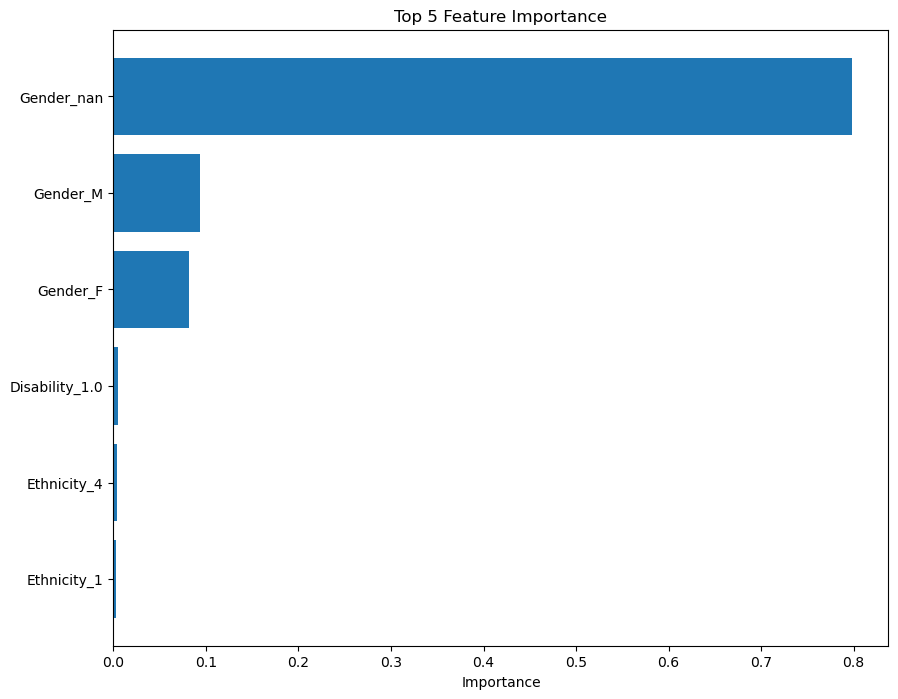

In [32]:
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = list(ohe_feature_names) + numeric_features
feature_importances = pipeline.named_steps['classifier'].feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print(feature_importance_df)

# plt.figure(figsize=(10, 8))
# plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
# plt.xlabel('Importance')
# plt.title('Feature Importance')
# plt.gca().invert_yaxis()
# plt.show()

top_features = feature_importance_df[:6]
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title('Top 5 Feature Importance')
plt.gca().invert_yaxis()
plt.show()

**Shap Values**

All-NaN slice encountered
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


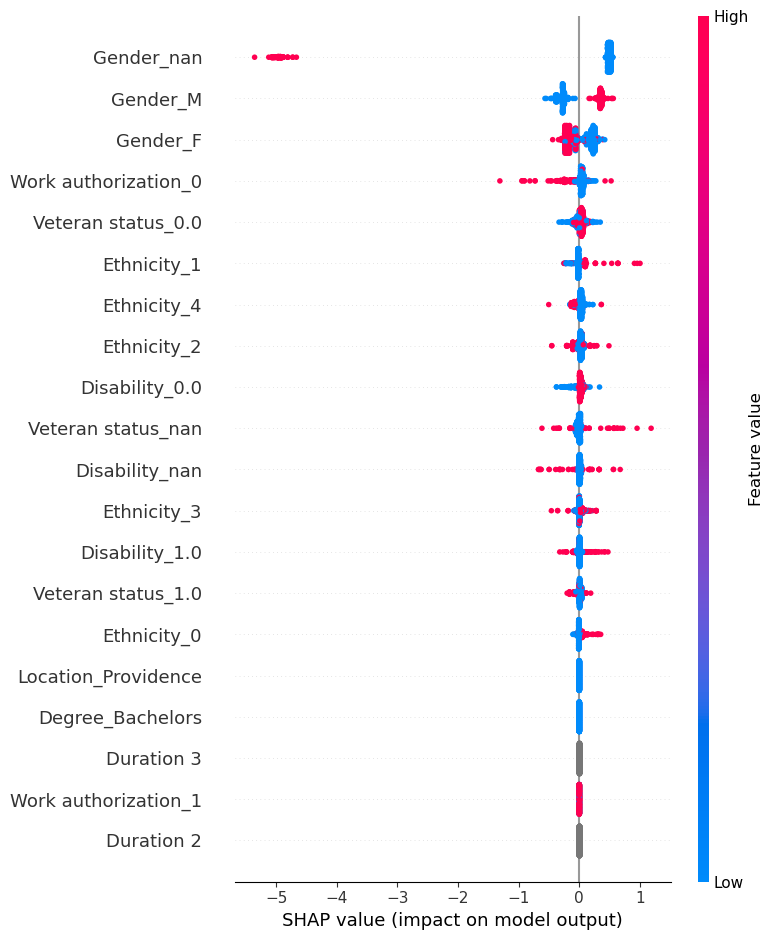

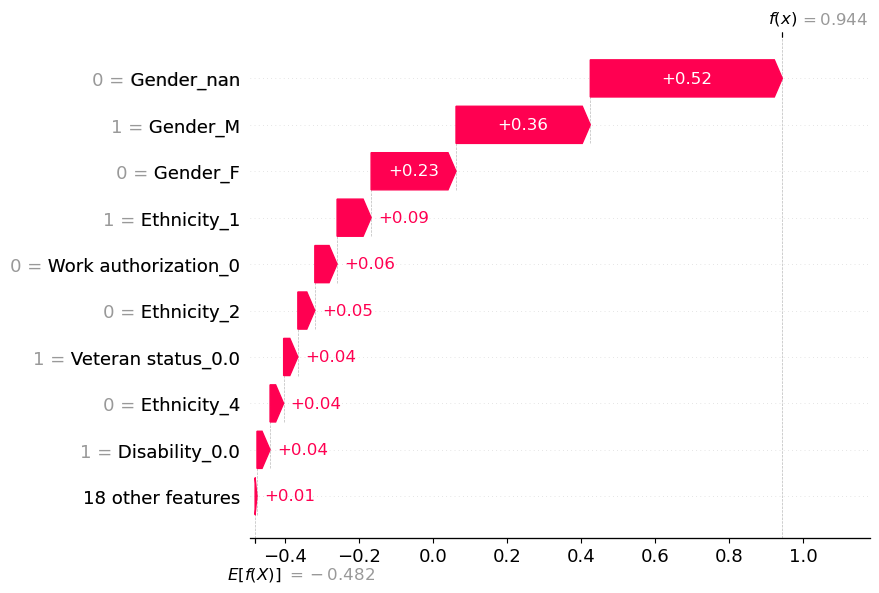

In [25]:
import shap

explainer = shap.Explainer(pipeline.named_steps['classifier'], pipeline.named_steps['preprocessor'].transform(X_train))
shap_values = explainer(pipeline.named_steps['preprocessor'].transform(X_test))
shap_values.feature_names = feature_names
shap.summary_plot(shap_values, pipeline.named_steps['preprocessor'].transform(X_test))
shap.plots.waterfall(shap_values[0])
# selected_features = ['Gender_nan', 'Gender_M', 'Gender_F']
# for feature in selected_features:
#     shap.dependence_plot(feature, shap_values.values, pipeline.named_steps['preprocessor'].transform(X_test), feature_names=feature_names)

# print(shap_values)

